In [1]:
import numpy as np
import open3d as o3d
from scipy.spatial import ConvexHull, cKDTree

# Assumed real chair height in meters (backrest top to floor)
REAL_CHAIR_HEIGHT_M = 0.9

# Material density in kg/m^3 (wood-ish)
DENSITY_KG_M3 = 600.0


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def load_point_cloud_from_ply(ply_path):
    pcd = o3d.io.read_point_cloud(ply_path)
    pts = np.asarray(pcd.points, dtype=np.float32)
    print("Loaded points:", pts.shape)
    return pts

# TODO: set your actual path
PLY_PATH = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply"
points = load_point_cloud_from_ply(PLY_PATH)


Loaded points: (284544, 3)


In [3]:
def rescale_points_to_real_height(points, real_height_m=0.9):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    extents = maxs - mins
    height_axis = np.argmax(extents)  # axis 0/1/2 with max extent

    pc_height = extents[height_axis]
    scale = real_height_m / pc_height

    pts_scaled = points * scale
    print(f"Original extents: {extents}")
    print(f"Rescaling axis {height_axis} from {pc_height:.4f} to {real_height_m} m (scale={scale:.4f})")
    return pts_scaled, scale

points_scaled, scale = rescale_points_to_real_height(points, REAL_CHAIR_HEIGHT_M)


Original extents: [0.5988158  0.66255766 0.997632  ]
Rescaling axis 2 from 0.9976 to 0.9 m (scale=0.9021)


In [4]:
def debug_extents(pts, label=""):
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    extents = maxs - mins
    print(f"{label} mins:", mins)
    print(f"{label} maxs:", maxs)
    print(f"{label} extents:", extents)
    print(f"{label} bbox volume:", extents.prod())

debug_extents(points_scaled, label="Scaled")


Scaled mins: [-0.26920006 -0.3002792  -0.45020708]
Scaled maxs: [0.27101335 0.29743806 0.44979292]
Scaled extents: [0.5402134 0.5977173 0.9      ]
Scaled bbox volume: 0.2906054


In [5]:
def volume_convex_hull(points):
    hull = ConvexHull(points)
    return float(hull.volume)

vol_hull = volume_convex_hull(points_scaled)
print("Convex hull volume (m^3):", vol_hull)
print("Convex hull mass (kg):", vol_hull * DENSITY_KG_M3)


Convex hull volume (m^3): 0.2077903796737834
Convex hull mass (kg): 124.67422780427003


## METHOD 2

In [6]:
def volume_bbox_fill(points, fill_factor=0.25):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    extents = maxs - mins
    bbox_vol = float(extents.prod())
    return bbox_vol * fill_factor

FILL_FACTOR = 0.25  # tweak this
vol_bbox = volume_bbox_fill(points_scaled, FILL_FACTOR)
print("BBox*fill volume (m^3):", vol_bbox)
print("BBox*fill mass (kg):", vol_bbox * DENSITY_KG_M3)


BBox*fill volume (m^3): 0.07265134900808334
BBox*fill mass (kg): 43.590809404850006


In [9]:
def volume_voxel(points, grid_resolution=64, min_points_per_voxel=300):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    extents = maxs - mins

    max_extent = extents.max()
    voxel_size = max_extent / grid_resolution

    xs = np.linspace(mins[0], maxs[0], grid_resolution)
    ys = np.linspace(mins[1], maxs[1], grid_resolution)
    zs = np.linspace(mins[2], maxs[2], grid_resolution)
    grid_x, grid_y, grid_z = np.meshgrid(xs, ys, zs, indexing="ij")
    centers = np.stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()], axis=-1)

    tree = cKDTree(points)
    radius = voxel_size * 1.0

    neighbors = tree.query_ball_point(centers, r=radius)
    occupied = np.array([len(n) >= min_points_per_voxel for n in neighbors])

    num_occ = occupied.sum()
    vol = num_occ * (voxel_size ** 3)
    return vol, voxel_size, num_occ

vol_vox, vox_size, num_occ = volume_voxel(points_scaled, grid_resolution=64, min_points_per_voxel=3)
print("Voxel volume (m^3):", vol_vox)
print("Voxel mass (kg):", vol_vox * DENSITY_KG_M3)
print("Voxel size (m):", vox_size, "occupied voxels:", num_occ)


Voxel volume (m^3): 0.07802966832878809
Voxel mass (kg): 46.817800997272855
Voxel size (m): 0.01406249962747097 occupied voxels: 28059


In [10]:
print("=== Volume comparison (scaled to real height) ===")
print(f"Convex hull:  {vol_hull:.5f} m^3  -> {vol_hull * DENSITY_KG_M3:.2f} kg")
print(f"BBox*fill:    {vol_bbox:.5f} m^3  -> {vol_bbox * DENSITY_KG_M3:.2f} kg")
print(f"Voxel occ.:   {vol_vox:.5f} m^3  -> {vol_vox * DENSITY_KG_M3:.2f} kg")


=== Volume comparison (scaled to real height) ===
Convex hull:  0.20779 m^3  -> 124.67 kg
BBox*fill:    0.07265 m^3  -> 43.59 kg
Voxel occ.:   0.07803 m^3  -> 46.82 kg


In [1]:
import open3d as o3d
import numpy as np


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:


import open3d as o3d

# Replace 'your_point_cloud_file.ply' with your actual file name.
point_cloud = o3d.io.read_point_cloud("/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply")

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [5]:
point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))


In [6]:
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=9)
o3d.visualization.draw_geometries([mesh], window_name="Mesh from Point Cloud")


[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [7]:
volume = mesh.get_volume()
print(f"Volume of the mesh: {volume:.4f}")


RuntimeError: [1;31m[Open3D Error] (double open3d::geometry::TriangleMesh::GetVolume() const) /root/Open3D/cpp/open3d/geometry/TriangleMesh.cpp:1201: The mesh is not watertight, and the volume cannot be computed.
[0;m

In [8]:
import open3d as o3d

# Load the point cloud
pcd = o3d.io.read_point_cloud("/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply")

# Estimate normals if not present
pcd.estimate_normals()

# Create a mesh using Poisson reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# Optionally, you can remove the low-density area (optional step)
# densities = np.asarray(densities)
# mesh.remove_unreferenced_vertices()
# mesh.remove_degenerate_triangles()

# Save the mesh
o3d.io.write_triangle_mesh("output_mesh.ply", mesh)




[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.IsoSurface.specialized.inl (Line 1858)
          Extract
          bad average roots: 5


True

In [9]:
volume = mesh.get_volume()
print(f"Volume of the mesh: {volume:.4f}")


RuntimeError: [1;31m[Open3D Error] (double open3d::geometry::TriangleMesh::GetVolume() const) /root/Open3D/cpp/open3d/geometry/TriangleMesh.cpp:1201: The mesh is not watertight, and the volume cannot be computed.
[0;m

In [7]:
import numpy as np
import trimesh
from pathlib import Path

PLY_PATH = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply"
OUT_DIR = Path("./renders_rot_pc")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [8]:
geom = trimesh.load(PLY_PATH, process=False)
print("Loaded type:", type(geom))

if isinstance(geom, trimesh.points.PointCloud):
    pc = geom
elif isinstance(geom, trimesh.Trimesh):
    # Convert mesh vertices to a point cloud
    pc = trimesh.points.PointCloud(geom.vertices)
else:
    raise TypeError(f"Unsupported geometry type: {type(geom)}")

points = pc.vertices.view(np.ndarray)
print("Point cloud shape:", points.shape)
print("First 5 points:\n", points[:5])


Loaded type: <class 'trimesh.points.PointCloud'>
Point cloud shape: (284544, 3)
First 5 points:
 [[-0.2965996  -0.32242531 -0.49298623]
 [-0.29513222 -0.32174891 -0.49267328]
 [-0.29427677 -0.32190892 -0.49337107]
 [-0.29482794 -0.319893   -0.49371079]
 [-0.2940523  -0.32087564 -0.49382797]]


In [9]:
scene = trimesh.Scene(pc)
scene.show(jupyter=True)  # interactive 3D viewer


In [10]:
import trimesh.transformations as tra

def render_rotated_view_pointcloud(pc, angle_deg, axis=(0, 1, 0), resolution=(800, 800)):
    """
    Rotate a copy of the point cloud and render as an image.
    angle_deg: rotation angle in degrees
    axis: rotation axis (default: Y-axis)
    """
    angle_rad = np.deg2rad(angle_deg)

    # Use centroid of the point cloud as rotation center
    center = pc.centroid
    R = tra.rotation_matrix(angle_rad, axis, point=center)

    pc_rot = pc.copy()
    pc_rot.apply_transform(R)

    scene_rot = trimesh.Scene(pc_rot)
    png = scene_rot.save_image(resolution=resolution, visible=True)
    return png


In [11]:
angles = [0, 90, 180, 270]
image_paths = []

for a in angles:
    png_bytes = render_rotated_view_pointcloud(pc, a, axis=(0, 1, 0))  # rotate around Y
    out_path = OUT_DIR / f"pc_view_{a:03d}.png"
    with open(out_path, "wb") as f:
        f.write(png_bytes)
    image_paths.append(out_path)
    print("Saved:", out_path)


ImportError: `trimesh.viewer.windowed` requires `pip install "pyglet<2"`

In [12]:
def viz(
    points,
    colors=None,
    ax=None,
    *,
    elev=0,
    azim=0,
    size=1,
    cmap="turbo",
    title=None,
    vmin=None,
    vmax=None,
    discrete=False,
    palette_type="default",
    show_colorbar=True,
    cbar_kwargs=None,
    label_names=None,
    scene_bounds=None,
    rotation=None,
):
    """
    3-D scatter that automatically adds:

      • a colour-bar (continuous scalar data), or
      • a legend   (discrete labels).

    Parameters
    ----------
    points : (N,3) float
    colors : (N,3) RGB | (N,) scalars | (N,) int labels
    discrete       : True → treat *colors* as integer part labels
    palette_type   : choose alternative palettes (future-proof)
    label_names    : optional list/array mapping label-id → text in legend
    rotation : None or length-3 list/tuple of floats
        Euler angles in degrees (rot_x, rot_y, rot_z).  If provided, each
        point is rotated by rot_x about the X-axis, then rot_y about Y, then
        rot_z about Z (all in degrees) before plotting.
    """

    # --- figure / axis boilerplate -----------------------------------------
    created_fig = False
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        created_fig = True
    else:
        fig = ax.get_figure()

    # ------------------------------------------------------------------
    # Optional clipping to an axis-aligned bounding box (scene_bounds)
    # scene_bounds should be ((xmin, ymin, zmin), (xmax, ymax, zmax)).
    # Points outside are discarded from the plot.  Axis limits are set so
    # the resulting view is nicely framed to that box.
    # ------------------------------------------------------------------

    pts = np.asarray(points)
    if colors is None:
        cols = np.full((len(points), 3), 0.5)  # Gray color for all points
    else:
        cols = colors
    
    # --- Apply rotation if requested ---------------------------------------
    if rotation is not None:
        # Expect rotation = [rot_x, rot_y, rot_z], in degrees
        rot = np.asarray(rotation, dtype=float)
        if rot.shape != (3,):
            raise ValueError("`rotation` must be a length‐3 iterable: [rot_x, rot_y, rot_z] in degrees.")

        # Convert degrees → radians
        rx, ry, rz = np.deg2rad(rot)

        # Rotation matrix around X-axis
        Rx = np.array([
            [1,          0,           0],
            [0, np.cos(rx), -np.sin(rx)],
            [0, np.sin(rx),  np.cos(rx)]
        ])

        # Rotation matrix around Y-axis
        Ry = np.array([
            [ np.cos(ry), 0, np.sin(ry)],
            [          0, 1,          0],
            [-np.sin(ry), 0, np.cos(ry)]
        ])

        # Rotation matrix around Z-axis
        Rz = np.array([
            [np.cos(rz), -np.sin(rz), 0],
            [np.sin(rz),  np.cos(rz), 0],
            [         0,           0, 1]
        ])

        # Combined rotation: first X, then Y, then Z
        R = Rz @ Ry @ Rx
        # Apply to all points
        pts = pts @ R.T
    # ------------------------------------------------------------------------
    
    if scene_bounds is not None:
        bmin = np.asarray(scene_bounds[0])
        bmax = np.asarray(scene_bounds[1])
        msk = np.all((pts >= bmin) & (pts <= bmax), axis=1)
        if msk.any():
            pts = pts[msk]
            cols = cols[msk]

    # --- colour handling ----------------------------------------------------
    rgb, is_scalar, norm, legend_info = _prep_colors(
        cols,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        discrete=discrete,
        palette_type=palette_type,
    )

    sc = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=size, c=rgb)
    ax.view_init(elev=elev, azim=azim)
    if title:
        ax.set_title(title)

    # --- continuous colour-bar ---------------------------------------------
    if is_scalar and show_colorbar:
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        kw = dict(shrink=0.75, pad=0.02)
        if cbar_kwargs:
            kw.update(cbar_kwargs)
        fig.colorbar(sm, ax=ax, **kw)

    # --- discrete legend ----------------------------------------------------
    if discrete and legend_info is not None:
        uniq_labels, uniq_cols = legend_info
        handles = [Patch(facecolor=col, edgecolor="k") for col in uniq_cols]
        if label_names is not None:
            texts = [label_names[int(i)] for i in uniq_labels]
        else:
            texts = [str(int(i)) for i in uniq_labels]
        # Keep legend tight to the plot; feel free to tweak loc/fontsize
        ax.legend(
            handles,
            texts,
            title="Part label",
            loc="upper center",
            ncols=3,
              bbox_to_anchor=(0.5, 1.0),
            borderaxespad=0.2,
            frameon=False,
        )

    # Apply axis limits if scene_bounds provided
    if scene_bounds is not None:
        ax.set_xlim(bmin[0], bmax[0])
        ax.set_ylim(bmin[1], bmax[1])
        ax.set_zlim(bmin[2], bmax[2])

    return ax

In [15]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt

PLY_PATH = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply"

geom = trimesh.load(PLY_PATH, process=False)
print("Loaded type:", type(geom))

# Ensure we always get an (N,3) array of points
if isinstance(geom, trimesh.points.PointCloud):
    points = geom.vertices.view(np.ndarray)
elif isinstance(geom, trimesh.Trimesh):
    points = geom.vertices.view(np.ndarray)   # fallback: use vertices only
else:
    raise TypeError(f"Unsupported geometry type: {type(geom)}")

print("Loaded point cloud shape:", points.shape)
print(points[:5])  # preview first 5 points


Loaded type: <class 'trimesh.points.PointCloud'>
Loaded point cloud shape: (284544, 3)
[[-0.2965996  -0.32242531 -0.49298623]
 [-0.29513222 -0.32174891 -0.49267328]
 [-0.29427677 -0.32190892 -0.49337107]
 [-0.29482794 -0.319893   -0.49371079]
 [-0.2940523  -0.32087564 -0.49382797]]


NameError: name '_prep_colors' is not defined

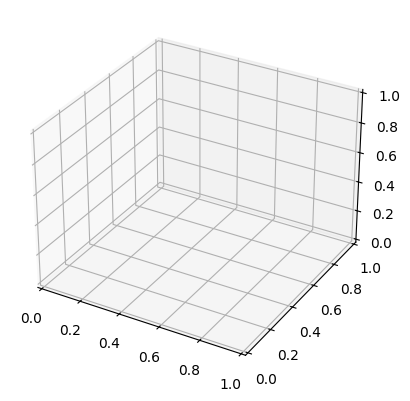

In [16]:
# Just visualize the raw point cloud — no rotation, no labels, no colors
viz(points, size=1, show_colorbar=False)


In [17]:
print("pc type:", type(pc))

print("vertices shape:", pc.vertices.shape)
print("vertices min:", pc.vertices.min(axis=0))
print("vertices max:", pc.vertices.max(axis=0))

# Colors may not exist or may be all transparent
cols = getattr(pc, "colors", None)
print("has colors?", cols is not None)
if cols is not None:
    print("colors shape:", cols.shape)
    print("colors dtype:", cols.dtype)
    print("first 5 colors:\n", cols[:5])


pc type: <class 'trimesh.points.PointCloud'>
vertices shape: (284544, 3)
vertices min: [-0.29840291 -0.3328535  -0.49904558]
vertices max: [0.30041289 0.32970417 0.49858648]
has colors? True
colors shape: (0,)
colors dtype: float64
first 5 colors:
 []


NameError: name '_prep_colors' is not defined

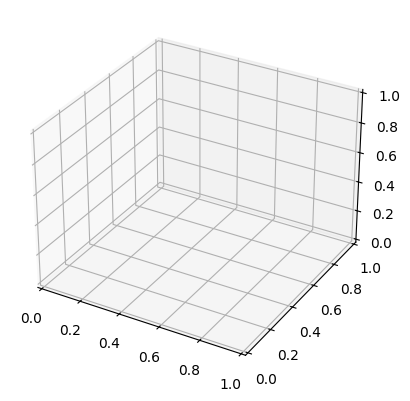

In [19]:
pc = trimesh.load("/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply")

points = np.asarray(pc.vertices)

cols = getattr(pc, "colors", None)
if cols is None or len(cols) != len(points):
    cols = None  # fall back to default grey in viz()

viz(points, colors=cols, size=1, show_colorbar=False)

In [21]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt

# Jupyter backend
%matplotlib inline

pc = trimesh.load("/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply")
points = np.asarray(pc.vertices)

print("points shape:", points.shape)
print("min:", points.min(axis=0), "max:", points.max(axis=0))


points shape: (284544, 3)
min: [-0.29840291 -0.3328535  -0.49904558] max: [0.30041289 0.32970417 0.49858648]


In [22]:
def show_pointcloud(points,
                    size=1,
                    elev=20,
                    azim=30,
                    title=None,
                    max_points=100000):
    """
    Simple 3D scatter for (N, 3) point cloud using matplotlib.
    - points: (N, 3)
    - max_points: randomly subsample for speed/visibility if too dense
    """
    pts = np.asarray(points)
    if pts.ndim != 2 or pts.shape[1] != 3:
        raise ValueError(f"Expected (N, 3) points, got {pts.shape}")

    # Optional random subsampling to avoid overplotting
    if len(pts) > max_points:
        idx = np.random.choice(len(pts), size=max_points, replace=False)
        pts = pts[idx]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=size)

    # Equal aspect ratio
    xyz_min = pts.min(axis=0)
    xyz_max = pts.max(axis=0)
    centers = (xyz_min + xyz_max) / 2.0
    max_range = (xyz_max - xyz_min).max() / 2.0

    ax.set_xlim(centers[0] - max_range, centers[0] + max_range)
    ax.set_ylim(centers[1] - max_range, centers[1] + max_range)
    ax.set_zlim(centers[2] - max_range, centers[2] + max_range)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    if title:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()


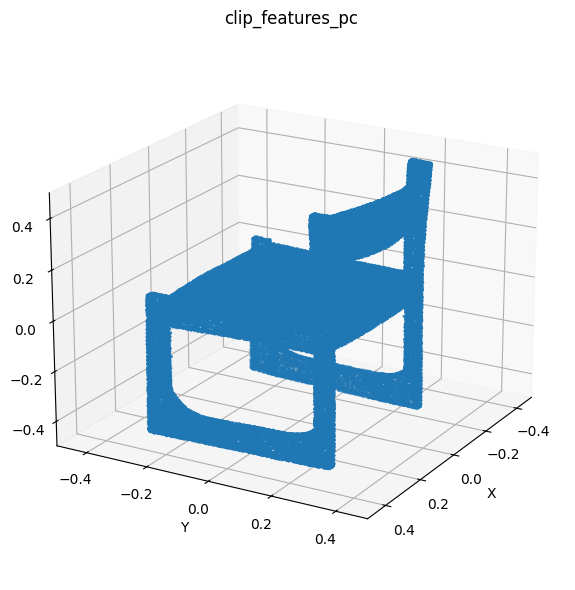

In [23]:
show_pointcloud(points, size=1, elev=20, azim=30, title="clip_features_pc")


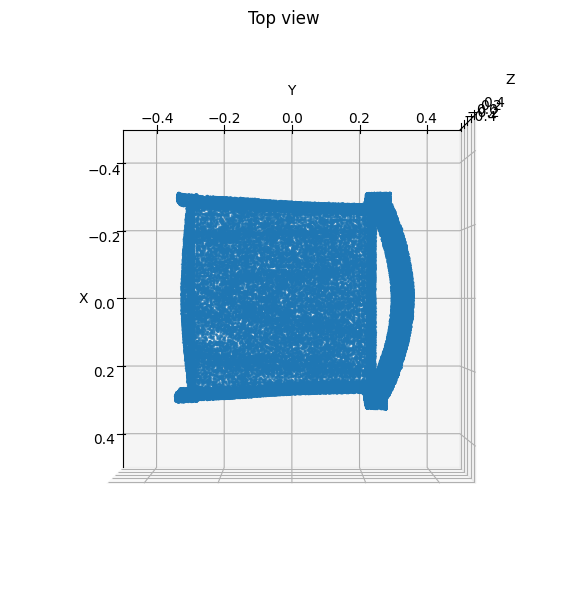

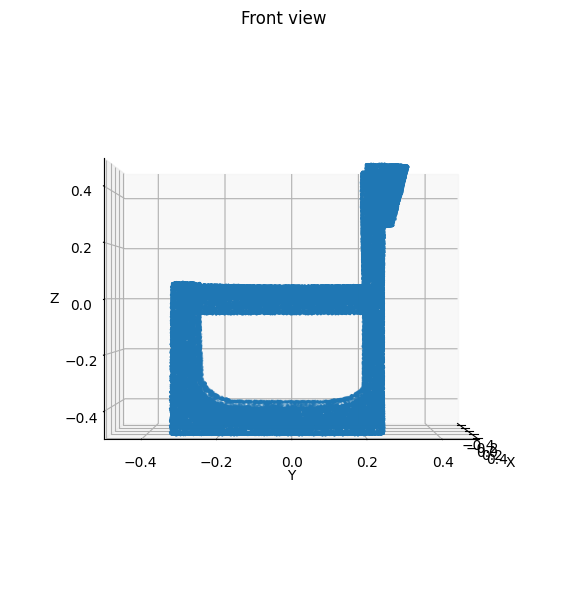

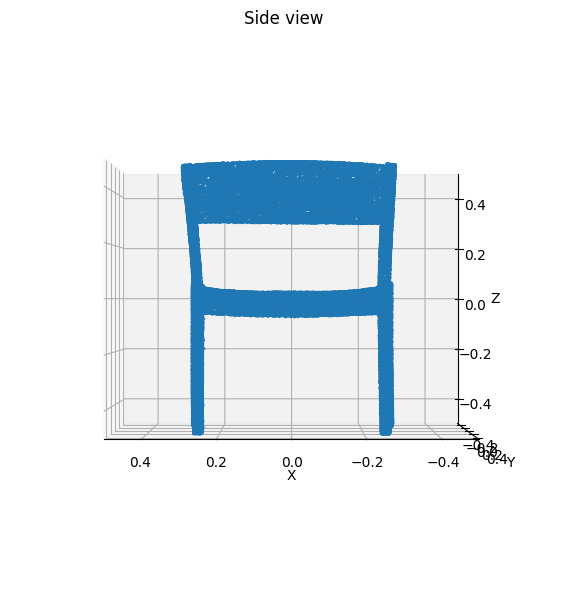

In [24]:
show_pointcloud(points, size=1, elev=90, azim=0,  title="Top view")
show_pointcloud(points, size=1, elev=0,  azim=0,  title="Front view")
show_pointcloud(points, size=1, elev=0,  azim=90, title="Side view")


In [25]:
import numpy as np

def compute_com_uniform(points: np.ndarray) -> np.ndarray:
    """
    Center of mass for a point cloud assuming
    each point has equal mass (uniform density).
    """
    points = np.asarray(points)
    if points.ndim != 2 or points.shape[1] != 3:
        raise ValueError(f"Expected (N, 3) points, got {points.shape}")
    return points.mean(axis=0)

com = compute_com_uniform(points)
print("Center of mass (uniform density):", com)


Center of mass (uniform density): [ 0.00086458  0.02287943 -0.01618254]


In [26]:
points_centered = points - com
print("Centered points min:", points_centered.min(axis=0))
print("Centered points max:", points_centered.max(axis=0))


Centered points min: [-0.29926748 -0.35573292 -0.48286304]
Centered points max: [0.29954831 0.30682474 0.51476902]


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def show_pointcloud_with_com(points,
                             com,
                             size=1,
                             elev=20,
                             azim=30,
                             title=None,
                             max_points=100000,
                             ax=None):
    """
    3D scatter of point cloud with COM overlay.
    - points: (N, 3)
    - com: (3,)
    - elev, azim: camera angles
    - if ax is None, a new figure is created
    """
    pts = np.asarray(points)
    com = np.asarray(com)

    if pts.ndim != 2 or pts.shape[1] != 3:
        raise ValueError(f"Expected (N,3) points, got {pts.shape}")
    if com.shape != (3,):
        raise ValueError(f"Expected com shape (3,), got {com.shape}")

    # Optional subsampling for speed
    if len(pts) > max_points:
        idx = np.random.choice(len(pts), size=max_points, replace=False)
        pts = pts[idx]

    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection="3d")
        created_fig = True
    else:
        fig = ax.get_figure()

    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=size)

    # COM marker
    ax.scatter([com[0]], [com[1]], [com[2]], s=50, marker="o", color="red")

    # Equal aspect across axes
    xyz_min = pts.min(axis=0)
    xyz_max = pts.max(axis=0)
    centers = (xyz_min + xyz_max) / 2.0
    max_range = (xyz_max - xyz_min).max() / 2.0

    ax.set_xlim(centers[0] - max_range, centers[0] + max_range)
    ax.set_ylim(centers[1] - max_range, centers[1] + max_range)
    ax.set_zlim(centers[2] - max_range, centers[2] + max_range)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    if title:
        ax.set_title(title)

    if created_fig:
        plt.tight_layout()
        plt.show()

    return ax


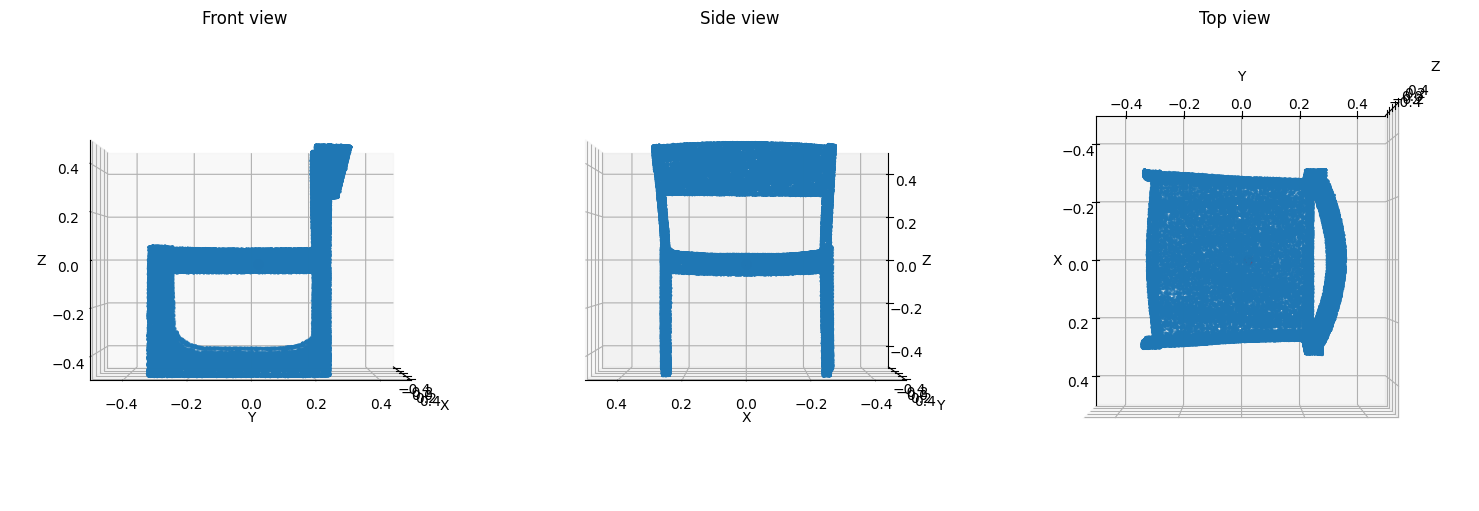

In [28]:
fig = plt.figure(figsize=(15, 5))

# Front view
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
show_pointcloud_with_com(points, com, size=1, elev=0, azim=0,
                         title="Front view", ax=ax1)

# Side view
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
show_pointcloud_with_com(points, com, size=1, elev=0, azim=90,
                         title="Side view", ax=ax2)

# Top view
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
show_pointcloud_with_com(points, com, size=1, elev=90, azim=0,
                         title="Top view", ax=ax3)

plt.tight_layout()
plt.show()


In [29]:
def show_pointcloud_with_com(points, com, elev, azim, size=1, max_points=80000, ax=None):
    pts = np.asarray(points)
    com = np.asarray(com)

    # Subsample for visibility
    if len(pts) > max_points:
        idx = np.random.choice(len(pts), size=max_points, replace=False)
        pts = pts[idx]

    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True

    # Light transparency to reveal COM
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=size, alpha=0.25)

    # COM shown as big filled + wireframe sphere
    ax.scatter([com[0]], [com[1]], [com[2]],
               s=500, color='red', edgecolors='black')

    # Wireframe sphere
    u = np.linspace(0, 2*np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    r = (pts.max(axis=0) - pts.min(axis=0)).max() * 0.03  # 3% scale

    xs = com[0] + r * np.outer(np.cos(u), np.sin(v))
    ys = com[1] + r * np.outer(np.sin(u), np.sin(v))
    zs = com[2] + r * np.outer(np.ones_like(u), np.cos(v))

    ax.plot_wireframe(xs, ys, zs, color='red', linewidth=0.8)

    # Equal aspect
    center = pts.mean(axis=0)
    max_range = (pts.max(axis=0) - pts.min(axis=0)).max()/2

    ax.set_xlim(center[0]-max_range, center[0]+max_range)
    ax.set_ylim(center[1]-max_range, center[1]+max_range)
    ax.set_zlim(center[2]-max_range, center[2]+max_range)

    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    if created_fig:
        plt.show()


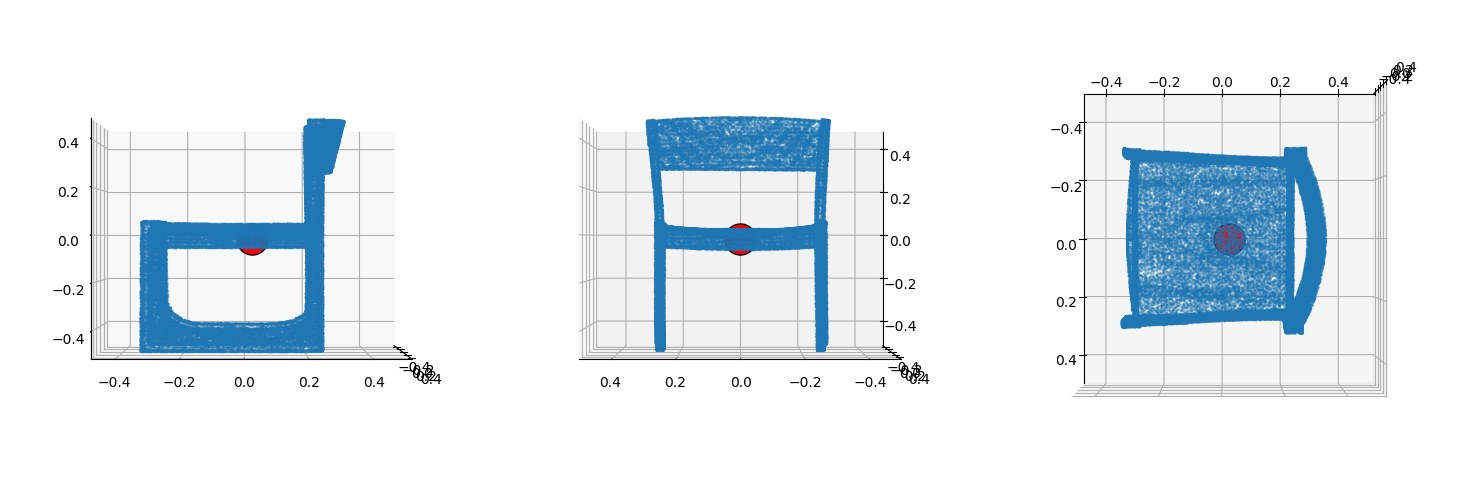

In [30]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,3,1, projection='3d')
show_pointcloud_with_com(points, com, elev=0,   azim=0,   ax=ax1)   # front

ax2 = fig.add_subplot(1,3,2, projection='3d')
show_pointcloud_with_com(points, com, elev=0,   azim=90,  ax=ax2)   # side

ax3 = fig.add_subplot(1,3,3, projection='3d')
show_pointcloud_with_com(points, com, elev=90,  azim=0,   ax=ax3)   # top

plt.tight_layout()
plt.show()


In [31]:
import numpy as np

def gaussian_weights(points, mu, sigma):
    """
    points: (N, 3)
    mu: (3,) center of Gaussian
    sigma: float, standard deviation (same for all axes for now)
    returns: (N,) weights
    """
    pts = np.asarray(points)
    mu = np.asarray(mu)
    diff = pts - mu
    d2 = np.sum(diff**2, axis=1)  # squared distance
    w = np.exp(-0.5 * d2 / (sigma**2))
    return w


In [32]:
def compute_com_weighted(points, weights):
    points = np.asarray(points)
    w = np.asarray(weights)
    total_w = w.sum()
    com_w = (points * w[:, None]).sum(axis=0) / total_w
    return com_w


In [33]:
sigma = 0.15  # choose something roughly on the scale of your object

w_centered = gaussian_weights(points, mu=com, sigma=sigma)
com_gauss_centered = compute_com_weighted(points, w_centered)

print("Uniform COM:        ", com)
print("Gaussian (centered):", com_gauss_centered)
print("Shift:", com_gauss_centered - com)


Uniform COM:         [ 0.00086458  0.02287943 -0.01618254]
Gaussian (centered): [0.00203725 0.02212123 0.006942  ]
Shift: [ 0.00117267 -0.00075819  0.02312454]


In [34]:
mu_shifted = com + np.array([0.0, 0.0, 0.1])  # 10 cm towards +Z
sigma = 0.15

w_shifted = gaussian_weights(points, mu=mu_shifted, sigma=sigma)
com_gauss_shifted = compute_com_weighted(points, w_shifted)

print("Uniform COM:         ", com)
print("Gaussian (shifted μ):", com_gauss_shifted)
print("Shift:", com_gauss_shifted - com)


Uniform COM:          [ 0.00086458  0.02287943 -0.01618254]
Gaussian (shifted μ): [0.00180939 0.02618991 0.02039218]
Shift: [0.00094482 0.00331048 0.03657473]


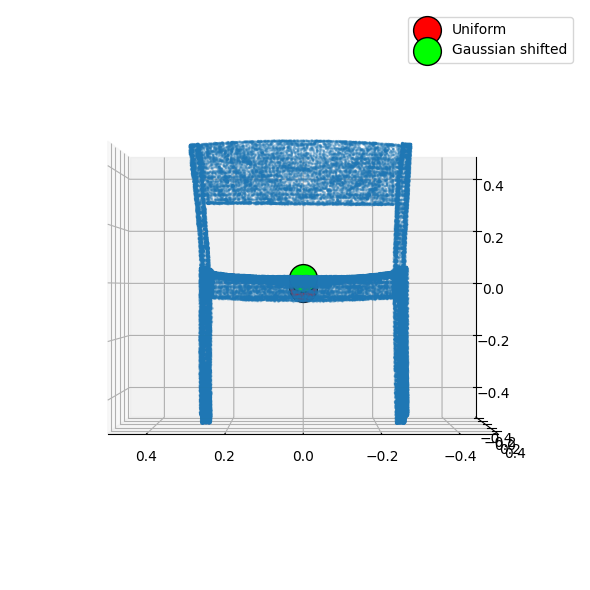

In [35]:
def show_pointcloud_two_com(points, com1, com2,
                            labels=("Uniform", "Gaussian"),
                            elev=20, azim=30, size=1, max_points=80000):
    pts = np.asarray(points)

    if len(pts) > max_points:
        idx = np.random.choice(len(pts), size=max_points, replace=False)
        pts = pts[idx]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=size, alpha=0.25)

    # COM 1 (uniform)
    ax.scatter([com1[0]], [com1[1]], [com1[2]],
               s=400, color='red', edgecolors='black', label=labels[0])

    # COM 2 (Gaussian-weighted)
    ax.scatter([com2[0]], [com2[1]], [com2[2]],
               s=400, color='lime', edgecolors='black', label=labels[1])

    # Equal aspect
    center = pts.mean(axis=0)
    max_range = (pts.max(axis=0) - pts.min(axis=0)).max()/2
    ax.set_xlim(center[0]-max_range, center[0]+max_range)
    ax.set_ylim(center[1]-max_range, center[1]+max_range)
    ax.set_zlim(center[2]-max_range, center[2]+max_range)

    ax.view_init(elev=elev, azim=azim)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example: compare uniform vs Gaussian-shifted
show_pointcloud_two_com(points, com, com_gauss_shifted,
                        labels=("Uniform", "Gaussian shifted"),
                        elev=0, azim=90)  # e.g. side view


In [36]:
def linear_density(points, axis=1, slope=1.0, intercept=1.0):
    pts = np.asarray(points)
    vals = pts[:, axis]
    rho = intercept + slope * vals
    rho = np.maximum(rho, 1e-6)  # avoid zeros
    return rho


In [37]:
w_lin = linear_density(points, axis=1, slope=-3.0, intercept=4.0)
com_lin = compute_com_weighted(points, w_lin)
print("Linear COM:", com_lin)


Linear COM: [ 0.00028221 -0.01235267 -0.03556151]


In [38]:
def piecewise_density(points, z_split=0.0, low_density=1.0, high_density=5.0):
    pts = np.asarray(points)
    w = np.where(pts[:,2] > z_split, high_density, low_density)
    return w


In [39]:
w_piece = piecewise_density(points, z_split=0.0, low_density=1.0, high_density=10.0)
com_piece = compute_com_weighted(points, w_piece)
print("Piecewise COM:", com_piece)


Piecewise COM: [0.00195286 0.06278079 0.12040789]
